In [107]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
from pytz import UTC, timezone
import seaborn as sns
from datetime import datetime, timedelta
import concurrent.futures

from watttime import WattTimeForecast, WattTimeHistorical, RecalculatingWattTimeOptimizer

import data.s3 as s3u
import evaluation.eval_framework as efu
from plotnine import *

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()

In [108]:
tz = "America/Chicago"

In [109]:
region = "SPP_TX"
start_time = datetime(2023, 7, 11, 20, 6)
start_time = UTC.localize(start_time)
end_time = start_time + timedelta(hours = 12)
usage_time = 120
usage_power = 2
optimization_method="simple"
requery_interval_minutes = 60

In [110]:
forecast_generator = WattTimeForecast(username, password)

In [111]:
moer_data_list = []

new_start_time = start_time

while new_start_time < end_time:
            
    new_data = forecast_generator.get_historical_forecast_pandas(
                start=new_start_time - timedelta(minutes=5), 
                end=new_start_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=72,
            )
    
    moer_data_list.append(new_data)
            
    new_start_time = new_start_time + timedelta(minutes = requery_interval_minutes)

In [112]:
opt_test = RecalculatingWattTimeOptimizer(region = region, 
                               watttime_username = username, 
                               watttime_password = password,
                               usage_time_required_minutes=usage_time,
                               usage_power_kw=usage_power,
                               optimization_method=optimization_method)

for curr_fcst_data in moer_data_list:
    new_start_time = pd.to_datetime(curr_fcst_data["point_time"]).min()
    print(new_start_time)
    opt_test.get_new_schedule(new_start_time=new_start_time, new_end_time=end_time, curr_fcst_data=curr_fcst_data)

2023-07-11 20:05:00+00:00
== Simple fit! ==
2023-07-11 21:05:00+00:00
== Simple fit! ==
2023-07-11 22:05:00+00:00
== Simple fit! ==
2023-07-11 23:05:00+00:00
== Simple fit! ==
2023-07-12 00:05:00+00:00
== Simple fit! ==
2023-07-12 01:05:00+00:00
== Simple fit! ==
2023-07-12 02:05:00+00:00
== Simple fit! ==
2023-07-12 03:05:00+00:00
== Simple fit! ==
2023-07-12 04:05:00+00:00
== Simple fit! ==
2023-07-12 05:05:00+00:00
== Simple fit! ==
2023-07-12 06:05:00+00:00
== Simple fit! ==
2023-07-12 07:05:00+00:00
== Simple fit! ==


In [113]:
opt_test.get_combined_schedule()

,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2023-07-11 20:05:00+00:00,1366.2,0.0,0.000000,0.000000
2023-07-11 20:10:00+00:00,1366.2,0.0,0.000000,0.000000
2023-07-11 20:15:00+00:00,1365.7,0.0,0.000000,0.000000
2023-07-11 20:20:00+00:00,1365.2,0.0,0.000000,0.000000
2023-07-11 20:25:00+00:00,1364.5,0.0,0.000000,0.000000
...,...,...,...,...
2023-07-12 07:45:00+00:00,141.8,5.0,0.023633,0.000167
2023-07-12 07:50:00+00:00,147.3,0.0,0.000000,0.000000
2023-07-12 07:55:00+00:00,154.0,0.0,0.000000,0.000000


In [114]:
test_moer = efu.get_schedule_and_cost_api_requerying(region=region,
                                         usage_power_kw=usage_power,
                                         time_needed=usage_time,
                                         start_time=start_time,
                                         end_time=end_time,
                                         moer_list=moer_data_list,
                                         optimization_method="simple")

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


In [115]:
test_minutes = efu.get_schedule_and_cost_api_requerying(region=region,
                                         usage_power_kw=usage_power,
                                         time_needed=usage_time,
                                         start_time=start_time,
                                         end_time=end_time,
                                         requery_interval_minutes=60,
                                         optimization_method="simple")

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


In [117]:
test_moer

,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2023-07-11 20:05:00+00:00,1366.2,0.0,0.000000,0.000000
2023-07-11 20:10:00+00:00,1366.2,0.0,0.000000,0.000000
2023-07-11 20:15:00+00:00,1365.7,0.0,0.000000,0.000000
2023-07-11 20:20:00+00:00,1365.2,0.0,0.000000,0.000000
2023-07-11 20:25:00+00:00,1364.5,0.0,0.000000,0.000000
...,...,...,...,...
2023-07-12 07:45:00+00:00,141.8,5.0,0.023633,0.000167
2023-07-12 07:50:00+00:00,147.3,0.0,0.000000,0.000000
2023-07-12 07:55:00+00:00,154.0,0.0,0.000000,0.000000


In [116]:
test_minutes

,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2023-07-11 20:05:00+00:00,1366.2,0.0,0.000000,0.000000
2023-07-11 20:10:00+00:00,1366.2,0.0,0.000000,0.000000
2023-07-11 20:15:00+00:00,1365.7,0.0,0.000000,0.000000
2023-07-11 20:20:00+00:00,1365.2,0.0,0.000000,0.000000
2023-07-11 20:25:00+00:00,1364.5,0.0,0.000000,0.000000
...,...,...,...,...
2023-07-12 07:45:00+00:00,141.8,5.0,0.023633,0.000167
2023-07-12 07:50:00+00:00,147.3,0.0,0.000000,0.000000
2023-07-12 07:55:00+00:00,154.0,0.0,0.000000,0.000000


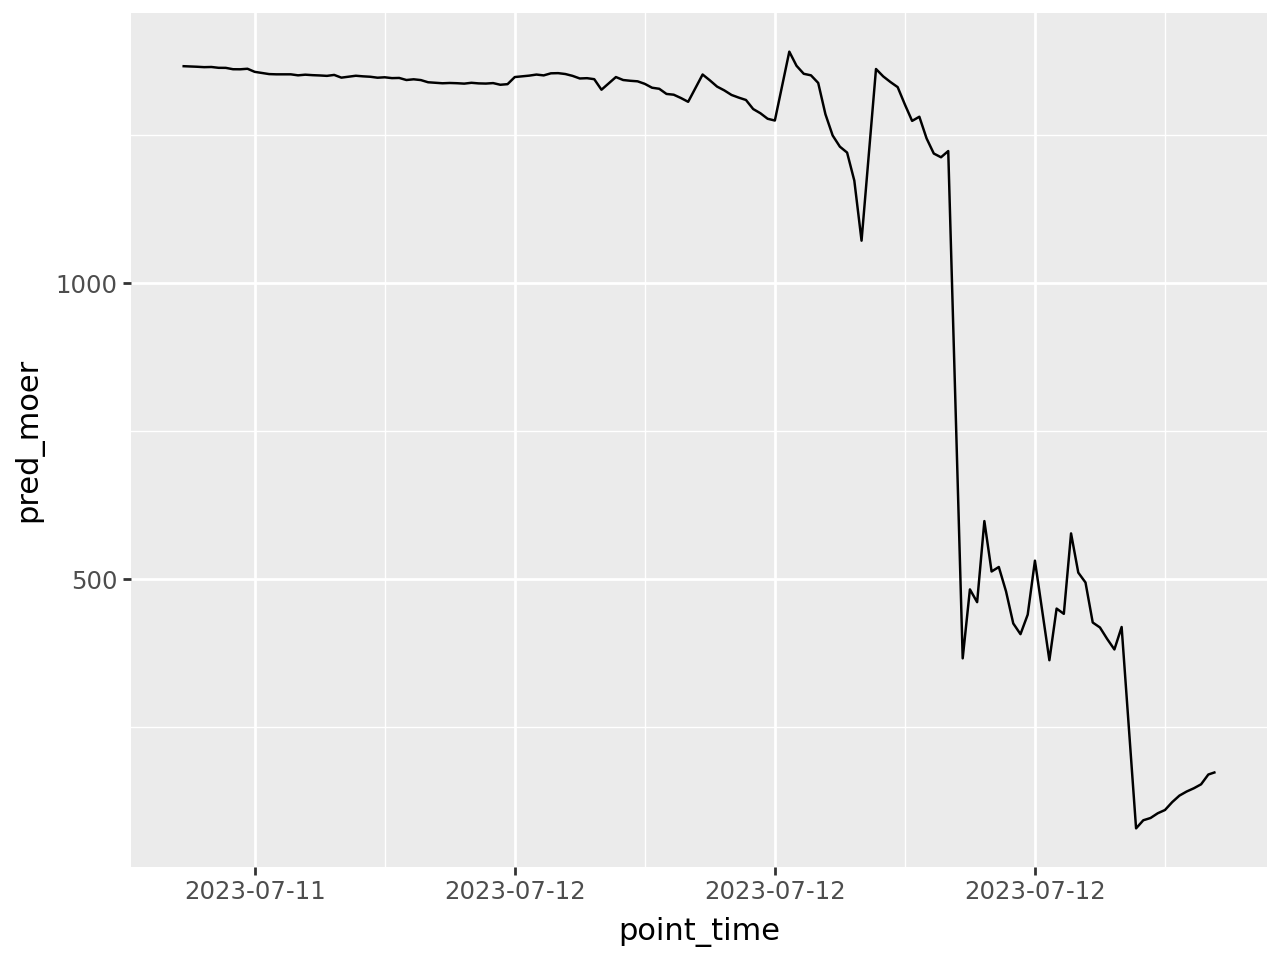

In [67]:
(ggplot(test_minutes.reset_index(), aes(x = "point_time", y = "pred_moer")) + geom_line())

In [65]:
test_moer.reset_index()["point_time"].drop_duplicates()

0     2023-07-11 20:05:00+00:00
1     2023-07-11 20:10:00+00:00
2     2023-07-11 20:15:00+00:00
3     2023-07-11 20:20:00+00:00
4     2023-07-11 20:25:00+00:00
                 ...           
140   2023-07-12 07:45:00+00:00
141   2023-07-12 07:50:00+00:00
142   2023-07-12 07:55:00+00:00
143   2023-07-12 08:00:00+00:00
144   2023-07-12 08:05:00+00:00
Name: point_time, Length: 145, dtype: datetime64[ns, UTC]

In [87]:
test_minutes.reset_index()["point_time"]

0     2023-07-11 20:05:00+00:00
1     2023-07-11 20:10:00+00:00
2     2023-07-11 20:15:00+00:00
3     2023-07-11 20:20:00+00:00
4     2023-07-11 20:25:00+00:00
                 ...           
127   2023-07-12 07:40:00+00:00
128   2023-07-12 07:45:00+00:00
129   2023-07-12 07:50:00+00:00
130   2023-07-12 08:00:00+00:00
131   2023-07-12 08:05:00+00:00
Name: point_time, Length: 132, dtype: datetime64[ns, UTC]

In [34]:
new_start_time

datetime.datetime(2023, 7, 12, 8, 6, tzinfo=<UTC>)

In [17]:
forecast_generator.get_historical_forecast_pandas(
                start=new_start_time - timedelta(days=5), 
                end=new_start_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=72,
            )

,point_time,value,generated_at
0,2023-07-07T07:10:00+00:00,981.2,2023-07-07 07:10:00+00:00
1,2023-07-07T07:15:00+00:00,981.2,2023-07-07 07:10:00+00:00
2,2023-07-07T07:20:00+00:00,955.2,2023-07-07 07:10:00+00:00
3,2023-07-07T07:25:00+00:00,985.9,2023-07-07 07:10:00+00:00
4,2023-07-07T07:30:00+00:00,988.5,2023-07-07 07:10:00+00:00
...,...,...,...
859,2023-07-15T06:40:00+00:00,1045.3,2023-07-12 07:05:00+00:00
860,2023-07-15T06:45:00+00:00,1045.3,2023-07-12 07:05:00+00:00
861,2023-07-15T06:50:00+00:00,1045.3,2023-07-12 07:05:00+00:00
862,2023-07-15T06:55:00+00:00,1045.3,2023-07-12 07:05:00+00:00


In [ ]:
moer_data_list[0]

In [ ]:
opt_test.